# Task-Scheduling-in-Edge-Computing

Note: You can run this project with randomly generated values for each graph or with the values that we have set. At the beginning of each segment there are lines that are commented out which generate random dataset. Un-comment those lines to generate random data. Keep them commented to run the code with the pre set values.

In [1]:
# import all pacckages required
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

# for formatting output
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Function to generate a single task with random values
def init_task(dataRate,dataSize,workload):
  task = {
      "dataRate": dataRate,
      "dataSize": dataSize,
      "workload": workload,
  }
  return task

# Function to generate multiple tasks by calling init_task()
def generateTasks(numTasks,dataRate,dataSize,workload):
  tasks=[]
  for i in range(numTasks):
    if(dataRate == 0):
      dr = random.randrange(50,100,10)
    else: 
      dr= dataRate
    
    if(dataSize == 0):
      ds = (random.randrange(5,45,5)/10)
    else:
      ds = dataSize
    
    if(workload == 0):
      wl = random.randrange(30,55,5)
    else: 
      wl = workload

    task=init_task(dr,ds,wl)
    tasks.append(task)
  return tasks 

# Function to create a server with given values
def init_server(buffer,freq,t_frac,arrivalRate,serviceRate):
  server={
      'buffer': buffer,
      'frequency': freq,
      'timeFraction' : t_frac,
      'arrivalRate': arrivalRate,
      'serviceRate': serviceRate,
      'prev_delay': 0
  }
  return server

# Function to geenrate multiple servers with given/random values
def generateServers(numServers,buffer,freq,arrRate,svcRate):
  servers = []
  for i in range(numServers):

    if(buffer == 0):
      taskBufferCapacity = random.randrange(4,11,1)
    else: 
      taskBufferCapacity = buffer

    if(freq == 0):
      frequency = random.randrange(1500,3300,300)
    else:
      frequency = freq

    if(arrRate == 0):
      arrivalRate = random.randrange(20,50,5)
    else:
      arrivalRate = arrRate

    if(svcRate == 0):
      serviceRate = random.randrange(250,310,10);
    else: 
      serviceRate = svcRate

    if(numServers == 4):
      time_fraction = 0.5
    elif(numServers == 5):
      time_fraction = 0.625    
    elif(numServers == 6):
      time_fraction = 0.75
    elif(numServers == 7):
      time_fraction = 0.875
    else:
      time_fraction = 0.9
    server = init_server(taskBufferCapacity,frequency,time_fraction,arrivalRate,serviceRate)
    servers.append(server)
  return servers

In [2]:
def greedyAlgo(run_tasks,generatedServersOriginal,generatedTasksOriginal,server_num,wup = 30):

  #make a copy of generated tasks and severs
  generatedServers = []
  generatedTasks = []

  #Duplicate Servers
  for li in generatedServersOriginal:
    d2 = copy.deepcopy(li)
    generatedServers.append(d2)
  
  #Duplicate tasks
  for li in generatedTasksOriginal:
    d2 = copy.deepcopy(li)
    generatedTasks.append(d2)

  # iterating through tasks
  server_alloc = []
  greedy_delay = []
  total_time = 0
  exec_time = []
  for i in range(run_tasks):
    #iterate through servers
    best_time = 1000
    best_server = -1
    best_delay = 0
    for j in range(server_num):
      if(generatedServers[j]['buffer']>=1):
        task_arrival = generatedServers[j]['arrivalRate'] * generatedServers[j]['timeFraction']                         # Aij
        # transmission_delay = task_arrival * (generatedTasks[i]['dataSize'] / generatedTasks[i]['dataRate'])           # Sum of transmission delay of all tasks
        transmission_delay = (generatedTasks[i]['dataSize']/generatedTasks[i]['dataRate'])                              # Lij transmission delay of each task
        computation_time = (generatedTasks[i]['workload'] / generatedServers[j]['frequency'])
        delay_sub = 0
        if(generatedServers[j]['prev_delay'] - transmission_delay > 0):
          delay_sub = generatedServers[j]['prev_delay'] - transmission_delay
        queuing_delay = (1000/ (generatedServers[j]['serviceRate'] - task_arrival))                                        # queuing delay for each task
        total_time = transmission_delay + queuing_delay + computation_time + delay_sub
        total_delay = transmission_delay + queuing_delay + delay_sub
        # print("Queue delay - ", queuing_delay, "Transmission delay - ",transmission_delay)
        #check if solution is better than previous
        if(best_time > total_time and transmission_delay + queuing_delay < wup):
          best_time = total_time
          best_server = j
          best_delay = total_delay
        else:
          # print('previous best time - {} for server - {}'.format(best_time, best_server))
          break
      # else: 
      #   print('Server :  {} cannot accomodate more tasks'.format(j))
    generatedServers[best_server]['buffer'] = generatedServers[best_server]['buffer'] - 1
    generatedServers[best_server]['prev_delay'] = generatedServers[best_server]['prev_delay'] + best_time
    # print('Task: {} ; alloted to server : {} , best time: {}'.format(i,best_server,best_time))
    server_alloc.append(best_server)
    greedy_delay.append(best_delay)
    exec_time.append(best_time)
  return server_alloc,greedy_delay,exec_time#,generatedServers



In [3]:
def swap_server(originalServer, number_servers,start=0):
  temp = list(range(start, originalServer)) + list(range(originalServer+1, number_servers-1))
  return random.choice(temp)

# Tabu search algorithm
def tabu_search(generatedServersOriginal,generatedTasksOriginal,greedy_policy_input, greedy_policy_time,tasks_to_run=30,wup =30 ):
  #make a copy of generated tasks and severs
  generatedServers = []
  generatedTasks = []

  #Duplicate Servers
  for li in generatedServersOriginal:
    d2 = copy.deepcopy(li)
    generatedServers.append(d2)
  
  #Duplicate tasks
  for li in generatedTasksOriginal:
    d2 = copy.deepcopy(li)
    generatedTasks.append(d2)

  tabu_policy = list(greedy_policy_input)
  greedy_time = list(greedy_policy_time)
  i=0
  while i< tasks_to_run: #Outer loop termination condition TBD
    total_time_tabu = []
    exec_time = 0
    temp = greedy_time[i]
    qtemp = tabu_policy[i]
    qbest = tabu_policy[i]
    h=0
    tabulist = []
    tabulist.append(tabu_policy[i])
    while h< 2:
      #Randomly swap allocated server to get qrand 
      qrand = swap_server(i,8)
      if(qrand not in tabulist and qrand <len(generatedServers) and generatedServers[qrand]['buffer'] >= 1):
        task_arrival = generatedServers[qrand]['arrivalRate'] * generatedServers[qrand]['timeFraction']                         # Aij  
        transmission_delay = (generatedTasksOriginal[i]['dataSize']/generatedTasksOriginal[i]['dataRate'])                              # Lij transmission delay of each task
        computation_time = (generatedTasksOriginal[i]['workload'] / generatedServers[qrand]['frequency'])
        delay_sub = 0
        if(generatedServers[qrand]['prev_delay'] - transmission_delay > 0):
          delay_sub = generatedServers[qrand]['prev_delay'] - transmission_delay
        # computation_time = computation_time * 10
        queuing_delay = (1000/ (generatedServers[qrand]['serviceRate'] - task_arrival))                                        # queuing delay for each task
        total_time = transmission_delay + queuing_delay + computation_time + delay_sub
        total_delay = transmission_delay + queuing_delay + delay_sub
        if(total_delay < temp and transmission_delay + queuing_delay < wup):
          # if(i < 2):
          #   print("Better solution found - ", temp, " old solution - ",total_delay, "new server - ",qrand, " old server - ",tabu_policy[i])
          h = 0
          exec_time = total_time
          temp = total_delay
          tabulist.append(qrand)
          qtemp = qrand
        else:
          h = h+1
    if(temp < greedy_time[i]):
      greedy_time[i] = temp
      tabu_policy[i] = qtemp
      total_time_tabu.append(exec_time)
      generatedServers[qtemp]['buffer'] = generatedServers[qtemp]['buffer'] - 1
      generatedServers[qtemp]['prev_delay'] = generatedServers[qtemp]['prev_delay'] + temp
    else:
      generatedServers[tabu_policy[i]]['buffer'] = generatedServers[tabu_policy[i]]['buffer'] - 1
      generatedServers[tabu_policy[i]]['prev_delay'] = generatedServers[tabu_policy[i]]['prev_delay'] + total_time
    i = i+1
  return tabu_policy, greedy_time,total_time_tabu


In [4]:
#Seeded dataset
common_servers=[{"buffer":8,"frequency":2400,"timeFraction":0.9,"arrivalRate":40,"serviceRate":300,"prev_delay":0},{"buffer":5,"frequency":2100,"timeFraction":0.9,"arrivalRate":25,"serviceRate":300,"prev_delay":0},{"buffer":4,"frequency":1800,"timeFraction":0.9,"arrivalRate":25,"serviceRate":290,"prev_delay":0},{"buffer":9,"frequency":1800,"timeFraction":0.9,"arrivalRate":40,"serviceRate":270,"prev_delay":0},{"buffer":4,"frequency":2400,"timeFraction":0.9,"arrivalRate":35,"serviceRate":290,"prev_delay":0},{"buffer":10,"frequency":2400,"timeFraction":0.9,"arrivalRate":25,"serviceRate":300,"prev_delay":0},{"buffer":5,"frequency":2100,"timeFraction":0.9,"arrivalRate":35,"serviceRate":290,"prev_delay":0},{"buffer":5,"frequency":2100,"timeFraction":0.9,"arrivalRate":45,"serviceRate":270,"prev_delay":0}];
common_tasks=[{"dataRate":70,"dataSize":3,"workload":30},{"dataRate":80,"dataSize":2.5,"workload":50},{"dataRate":80,"dataSize":2,"workload":30},{"dataRate":80,"dataSize":3.5,"workload":50},{"dataRate":60,"dataSize":2,"workload":45},{"dataRate":50,"dataSize":3,"workload":45},{"dataRate":70,"dataSize":2,"workload":45},{"dataRate":90,"dataSize":2,"workload":35},{"dataRate":50,"dataSize":2,"workload":35},{"dataRate":80,"dataSize":1,"workload":35},{"dataRate":60,"dataSize":1.5,"workload":50},{"dataRate":70,"dataSize":1.5,"workload":40},{"dataRate":90,"dataSize":2,"workload":50},{"dataRate":80,"dataSize":2.5,"workload":40},{"dataRate":90,"dataSize":3.5,"workload":40},{"dataRate":90,"dataSize":4,"workload":40},{"dataRate":60,"dataSize":2,"workload":35},{"dataRate":60,"dataSize":1.5,"workload":30},{"dataRate":90,"dataSize":3,"workload":40},{"dataRate":70,"dataSize":1,"workload":40},{"dataRate":50,"dataSize":2.5,"workload":50},{"dataRate":70,"dataSize":3.5,"workload":35},{"dataRate":90,"dataSize":3.5,"workload":35},{"dataRate":90,"dataSize":1.5,"workload":50},{"dataRate":70,"dataSize":1,"workload":30},{"dataRate":90,"dataSize":1,"workload":50},{"dataRate":60,"dataSize":3,"workload":45},{"dataRate":70,"dataSize":1,"workload":50},{"dataRate":80,"dataSize":3.5,"workload":45},{"dataRate":80,"dataSize":1,"workload":35}];

# Uncomment the lines below to randomly generate common tasks and servers for greedy and tabu search algo
# It creates common tasks and servers for greedy and tabu search algo
# generateServers(8,0,0,0,0)
# generateTasks(30,0,0,0)

print(common_servers)
print(common_tasks)


[{'buffer': 8, 'frequency': 2400, 'timeFraction': 0.9, 'arrivalRate': 40, 'serviceRate': 300, 'prev_delay': 0}, {'buffer': 5, 'frequency': 2100, 'timeFraction': 0.9, 'arrivalRate': 25, 'serviceRate': 300, 'prev_delay': 0}, {'buffer': 4, 'frequency': 1800, 'timeFraction': 0.9, 'arrivalRate': 25, 'serviceRate': 290, 'prev_delay': 0}, {'buffer': 9, 'frequency': 1800, 'timeFraction': 0.9, 'arrivalRate': 40, 'serviceRate': 270, 'prev_delay': 0}, {'buffer': 4, 'frequency': 2400, 'timeFraction': 0.9, 'arrivalRate': 35, 'serviceRate': 290, 'prev_delay': 0}, {'buffer': 10, 'frequency': 2400, 'timeFraction': 0.9, 'arrivalRate': 25, 'serviceRate': 300, 'prev_delay': 0}, {'buffer': 5, 'frequency': 2100, 'timeFraction': 0.9, 'arrivalRate': 35, 'serviceRate': 290, 'prev_delay': 0}, {'buffer': 5, 'frequency': 2100, 'timeFraction': 0.9, 'arrivalRate': 45, 'serviceRate': 270, 'prev_delay': 0}]
[{'dataRate': 70, 'dataSize': 3, 'workload': 30}, {'dataRate': 80, 'dataSize': 2.5, 'workload': 50}, {'dataRat

greedy delay -  60.04828357946474
tabu s delay - >  42.52254031897491
Greedy algo is 29.186085289677234% better
greedy delay -  102.871513679264
tabu s delay - >  85.8876430223077
Greedy algo is 16.50978978486614% better
greedy delay -  189.78699733237383
tabu s delay - >  125.62588887312133
Greedy algo is 33.806904245862114% better
greedy delay -  276.06581280394164
tabu s delay - >  211.2451392840368
Greedy algo is 23.480152381613305% better
greedy delay -  444.7096358102913
tabu s delay - >  356.63689894920753
Greedy algo is 19.80454880421226% better


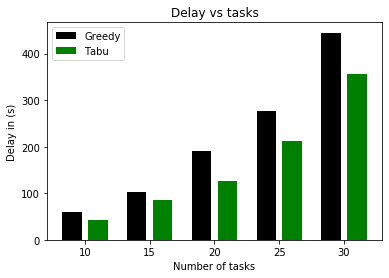

In [5]:
def difference(greed_policy, tabu_policy):
  print()
  print(greed_policy)
  for i in range(len(tabu_policy)):
    if(greed_policy[i] == tabu_policy[i]):
      print(bcolors.ENDC,greed_policy[i], end = ",")
    else:
      print(bcolors.FAIL,tabu_policy[i], end = ',')
  print(bcolors.ENDC)

def perc_diff(greedy_delay, tabu_delay):
  diff = 100 * ((sum(greedy_delay) - sum(tabu_delay))/sum(greedy_delay))
  print('Greedy algo is ' + bcolors.FAIL + '{}% better'.format(diff) + bcolors.ENDC)

def test():
  greedy_delays = []
  tabu_delays = []
  total_tasks = []
  for i in range(5):
    tasks = 10 + 5*i
    total_tasks.append(tasks)
    # get greedy policy 
    greed_policy, delay,total_time = greedyAlgo(tasks,common_servers,common_tasks,len(common_servers))
    greedy_delays.append(sum(delay))
    print("greedy delay - ",sum(delay))
    # print("greedy Total time - ",sum(total_time))

    tabu_policy,tabu_delay,tabu_total_time = tabu_search(common_servers,common_tasks,greed_policy,delay,tasks)
    tabu_delays.append(sum(tabu_delay))
    print('tabu s delay - > ',sum(tabu_delay))
    # print('tabu s total time - ',sum(tabu_total_time))

    # difference(greed_policy, tabu_policy)
    perc_diff(delay,tabu_delay)

  X_axis = np.arange(len(total_tasks))
  plt.bar(X_axis - 0.2,greedy_delays,0.3, color='black', label = 'Greedy')
  plt.bar(X_axis + 0.2,tabu_delays,0.3, color='green', label = 'Tabu')
  
  plt.xticks(X_axis, total_tasks)
  plt.xlabel("Number of tasks")
  plt.ylabel("Delay in (s)")
  plt.title("Delay vs tasks")
  plt.legend()
  plt.show()
  # plt.show()
test()

968.432156726412
890.8659129486258
824.9139869218645
768.1486831874429
718.7750201269654
[250 270 290 310 330]
[0.91682217 0.85087292 0.76427524 0.71971894 0.5262299 ]


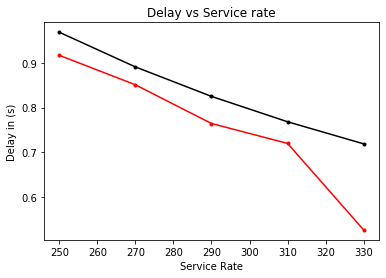

In [6]:
# service rate vs delay
common_tasks=[{"dataRate":60,"dataSize":3.5,"workload":45},{"dataRate":60,"dataSize":3,"workload":30},{"dataRate":70,"dataSize":4,"workload":30},{"dataRate":70,"dataSize":2.5,"workload":45},{"dataRate":80,"dataSize":2.5,"workload":50},{"dataRate":60,"dataSize":2.5,"workload":50},{"dataRate":60,"dataSize":3.5,"workload":30},{"dataRate":50,"dataSize":2.5,"workload":35},{"dataRate":70,"dataSize":4,"workload":35},{"dataRate":90,"dataSize":2.5,"workload":35},{"dataRate":80,"dataSize":3,"workload":30},{"dataRate":90,"dataSize":3,"workload":35},{"dataRate":50,"dataSize":4,"workload":35},{"dataRate":60,"dataSize":3,"workload":30},{"dataRate":50,"dataSize":2,"workload":40},{"dataRate":50,"dataSize":2,"workload":40},{"dataRate":80,"dataSize":4,"workload":50},{"dataRate":90,"dataSize":2,"workload":30},{"dataRate":80,"dataSize":3,"workload":45},{"dataRate":60,"dataSize":3,"workload":35},{"dataRate":80,"dataSize":1.5,"workload":50},{"dataRate":90,"dataSize":0.5,"workload":45},{"dataRate":70,"dataSize":1,"workload":45},{"dataRate":90,"dataSize":0.5,"workload":40},{"dataRate":60,"dataSize":1.5,"workload":45},{"dataRate":60,"dataSize":2,"workload":40},{"dataRate":60,"dataSize":0.5,"workload":40},{"dataRate":90,"dataSize":2.5,"workload":40},{"dataRate":90,"dataSize":4,"workload":45},{"dataRate":70,"dataSize":1.5,"workload":40}];
common_servers=[{"buffer":9,"frequency":1500,"timeFraction":0.75,"arrivalRate":40,"serviceRate":330,"prev_delay":0},{"buffer":4,"frequency":1500,"timeFraction":0.75,"arrivalRate":20,"serviceRate":330,"prev_delay":0},{"buffer":4,"frequency":2100,"timeFraction":0.75,"arrivalRate":30,"serviceRate":330,"prev_delay":0},{"buffer":10,"frequency":1800,"timeFraction":0.75,"arrivalRate":25,"serviceRate":330,"prev_delay":0},{"buffer":6,"frequency":1500,"timeFraction":0.75,"arrivalRate":25,"serviceRate":330,"prev_delay":0},{"buffer":9,"frequency":2700,"timeFraction":0.75,"arrivalRate":30,"serviceRate":330,"prev_delay":0}];

# Uncomment the lines below to randomly generate common tasks and servers 
# generateTasks(30,0,0,0)
# generateServers(6,0,0,0,250)

def service_rate_vs_delay():
  greedy_delays = []
  tabu_delays = []
  total_tasks = []
  tasks = 30
  svcRate = []
  for i in range(5):
    svcRate.append(250 + i* 20)
    for  j in range(len(common_servers)):
      common_servers[j]['serviceRate'] = 250 + i* 20
    greed_policy, delay,total_time = greedyAlgo(tasks,common_servers,common_tasks,len(common_servers))
    print(sum(delay))
    greedy_delays.append(sum(delay)/1000)

    tabu_policy,tabu_delay,tabu_total_time = tabu_search(common_servers,common_tasks,greed_policy,delay,tasks)
    tabu_delays.append(sum(tabu_delay)/1000)

  greedy_delays = np.array(greedy_delays)
  tabu_delays = np.array(tabu_delays)
  svcRate = np.array(svcRate)

  print(svcRate)
  print(tabu_delays)
  plt.plot(svcRate, (greedy_delays), marker= '.', color = 'black', label='greedy')
  plt.plot(svcRate, (tabu_delays), marker= '.', color = 'red', label = 'tabu')
  plt.xlabel("Service Rate")
  plt.ylabel("Delay in (s)")
  plt.title("Delay vs Service rate")
service_rate_vs_delay()


In [7]:
print(common_servers)
print(common_tasks)

[{'buffer': 9, 'frequency': 1500, 'timeFraction': 0.75, 'arrivalRate': 40, 'serviceRate': 330, 'prev_delay': 0}, {'buffer': 4, 'frequency': 1500, 'timeFraction': 0.75, 'arrivalRate': 20, 'serviceRate': 330, 'prev_delay': 0}, {'buffer': 4, 'frequency': 2100, 'timeFraction': 0.75, 'arrivalRate': 30, 'serviceRate': 330, 'prev_delay': 0}, {'buffer': 10, 'frequency': 1800, 'timeFraction': 0.75, 'arrivalRate': 25, 'serviceRate': 330, 'prev_delay': 0}, {'buffer': 6, 'frequency': 1500, 'timeFraction': 0.75, 'arrivalRate': 25, 'serviceRate': 330, 'prev_delay': 0}, {'buffer': 9, 'frequency': 2700, 'timeFraction': 0.75, 'arrivalRate': 30, 'serviceRate': 330, 'prev_delay': 0}]
[{'dataRate': 60, 'dataSize': 3.5, 'workload': 45}, {'dataRate': 60, 'dataSize': 3, 'workload': 30}, {'dataRate': 70, 'dataSize': 4, 'workload': 30}, {'dataRate': 70, 'dataSize': 2.5, 'workload': 45}, {'dataRate': 80, 'dataSize': 2.5, 'workload': 50}, {'dataRate': 60, 'dataSize': 2.5, 'workload': 50}, {'dataRate': 60, 'dataS

In [8]:
common_tasks=[{"dataRate":80,"dataSize":4,"workload":30},{"dataRate":70,"dataSize":1.5,"workload":45},{"dataRate":70,"dataSize":2.5,"workload":35},{"dataRate":60,"dataSize":1,"workload":30},{"dataRate":90,"dataSize":3.5,"workload":50},{"dataRate":60,"dataSize":3.5,"workload":30},{"dataRate":60,"dataSize":3.5,"workload":40},{"dataRate":50,"dataSize":1,"workload":45},{"dataRate":90,"dataSize":4,"workload":35},{"dataRate":50,"dataSize":1,"workload":40},{"dataRate":70,"dataSize":2,"workload":50},{"dataRate":50,"dataSize":1.5,"workload":40},{"dataRate":80,"dataSize":4,"workload":35},{"dataRate":90,"dataSize":4,"workload":30},{"dataRate":90,"dataSize":3,"workload":30},{"dataRate":80,"dataSize":0.5,"workload":30},{"dataRate":90,"dataSize":3.5,"workload":45},{"dataRate":50,"dataSize":1.5,"workload":30},{"dataRate":70,"dataSize":1,"workload":45},{"dataRate":90,"dataSize":2,"workload":45},{"dataRate":60,"dataSize":0.5,"workload":50},{"dataRate":60,"dataSize":1.5,"workload":35},{"dataRate":80,"dataSize":3.5,"workload":45},{"dataRate":80,"dataSize":3,"workload":30},{"dataRate":90,"dataSize":3.5,"workload":35},{"dataRate":70,"dataSize":2.5,"workload":50},{"dataRate":60,"dataSize":0.5,"workload":30},{"dataRate":90,"dataSize":1,"workload":40},{"dataRate":70,"dataSize":1.5,"workload":30},{"dataRate":50,"dataSize":1,"workload":30}];
common_servers=[{"buffer":5,"frequency":2700,"timeFraction":0.75,"arrivalRate":20,"serviceRate":260,"prev_delay":0},{"buffer":8,"frequency":1800,"timeFraction":0.75,"arrivalRate":45,"serviceRate":280,"prev_delay":0},{"buffer":10,"frequency":1500,"timeFraction":0.75,"arrivalRate":30,"serviceRate":290,"prev_delay":0},{"buffer":7,"frequency":2700,"timeFraction":0.75,"arrivalRate":35,"serviceRate":280,"prev_delay":0},{"buffer":9,"frequency":2100,"timeFraction":0.75,"arrivalRate":45,"serviceRate":250,"prev_delay":0},{"buffer":10,"frequency":2700,"timeFraction":0.75,"arrivalRate":30,"serviceRate":270,"prev_delay":0}];

# Uncomment the lines below to randomly generate common tasks and servers
# generateTasks(30,0,0,0)
# generateServers(6,0,0,0,0)

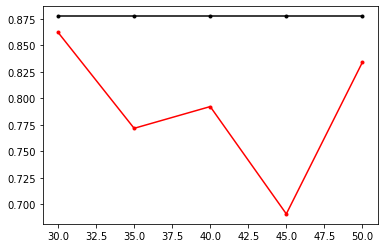

In [9]:
# wup vs delay
def wup_vs_delay():
  greedy_delays = []
  tabu_delays = []
  total_tasks = []
  tasks = 30
  wups = []
  for i in range(5):
    wup = 30 + i*5
    wups.append(wup)
    greed_policy, delay,total_time = greedyAlgo(tasks,common_servers,common_tasks,len(common_servers),wup)
    greedy_delays.append(sum(delay)/1000)

    tabu_policy,tabu_delay,tabu_total_time = tabu_search(common_servers,common_tasks,greed_policy,delay,tasks,wup)
    tabu_delays.append(sum(tabu_delay)/1000)

  greedy_delays = np.array(greedy_delays)
  tabu_delays = np.array(tabu_delays)

  wups = np.array(wups)
  plt.plot(wups, (greedy_delays), marker= '.', color = 'black')
  plt.plot(wups, (tabu_delays), marker= '.', color = 'red')
wup_vs_delay()

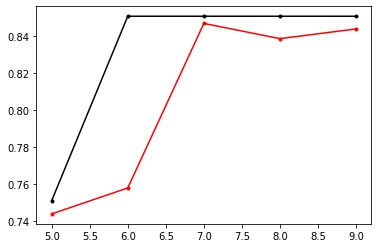

In [10]:
# length of queue vs delay
common_tasks=[{"dataRate":70,"dataSize":4,"workload":30},{"dataRate":60,"dataSize":4,"workload":45},{"dataRate":60,"dataSize":3,"workload":50},{"dataRate":50,"dataSize":2,"workload":50},{"dataRate":50,"dataSize":2,"workload":35},{"dataRate":70,"dataSize":4,"workload":35},{"dataRate":70,"dataSize":2.5,"workload":50},{"dataRate":50,"dataSize":3,"workload":30},{"dataRate":50,"dataSize":1,"workload":35},{"dataRate":70,"dataSize":3.5,"workload":35},{"dataRate":60,"dataSize":1.5,"workload":30},{"dataRate":90,"dataSize":1,"workload":30},{"dataRate":60,"dataSize":2,"workload":30},{"dataRate":60,"dataSize":3,"workload":30},{"dataRate":90,"dataSize":3.5,"workload":30},{"dataRate":90,"dataSize":0.5,"workload":30},{"dataRate":50,"dataSize":0.5,"workload":35},{"dataRate":80,"dataSize":4,"workload":50},{"dataRate":90,"dataSize":1,"workload":40},{"dataRate":50,"dataSize":0.5,"workload":50},{"dataRate":80,"dataSize":3,"workload":30},{"dataRate":50,"dataSize":2,"workload":45},{"dataRate":90,"dataSize":4,"workload":45},{"dataRate":90,"dataSize":1,"workload":40},{"dataRate":90,"dataSize":2.5,"workload":45},{"dataRate":50,"dataSize":4,"workload":35},{"dataRate":90,"dataSize":3.5,"workload":35},{"dataRate":80,"dataSize":4,"workload":45},{"dataRate":70,"dataSize":1,"workload":30},{"dataRate":60,"dataSize":3,"workload":50}];
common_servers=[{"buffer":9,"frequency":3000,"timeFraction":0.75,"arrivalRate":35,"serviceRate":290,"prev_delay":0},{"buffer":9,"frequency":3000,"timeFraction":0.75,"arrivalRate":45,"serviceRate":300,"prev_delay":0},{"buffer":9,"frequency":1500,"timeFraction":0.75,"arrivalRate":25,"serviceRate":280,"prev_delay":0},{"buffer":9,"frequency":1800,"timeFraction":0.75,"arrivalRate":35,"serviceRate":300,"prev_delay":0},{"buffer":9,"frequency":3000,"timeFraction":0.75,"arrivalRate":45,"serviceRate":250,"prev_delay":0},{"buffer":9,"frequency":1800,"timeFraction":0.75,"arrivalRate":25,"serviceRate":250,"prev_delay":0}];

# Uncomment the lines below to randomly generate common tasks and servers
# generateTasks(30,0,0,0)
# generateServers(6,5,0,0,0)

def q_vs_delay():
  qs = []
  greedy_delays = []
  tabu_delays = []

  for i in range(5):
    q_length = 5 + i
    for i in range(len(common_servers)):
      common_servers[i]['buffer'] = q_length
    
    qs.append(q_length)
    greed_policy, delay,total_time = greedyAlgo(len(common_tasks),common_servers,common_tasks,len(common_servers))
    greedy_delays.append(sum(delay)/1000)

    tabu_policy,tabu_delay,tabu_total_time = tabu_search(common_servers,common_tasks,greed_policy,delay)
    tabu_delays.append(sum(tabu_delay)/1000)

  greedy_delays = np.array(greedy_delays)
  tabu_delays = np.array(tabu_delays)
  qs = np.array(qs)

  plt.plot(qs,greedy_delays,marker = '.', color = 'black')
  plt.plot(qs,tabu_delays,marker = '.', color = 'red')

q_vs_delay()